In [4]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [5]:
#!pip install scikit-learn

In [7]:
dataset_directory='C:\Deep learning\Face Mask Detection\dataset'
labels=[]
data=[]
for file in os.listdir(dataset_directory):
    file_path=os.path.join(dataset_directory,file)
    for img in os.listdir(file_path):
        img_path=os.path.join(file_path,img)
        label = img_path.split(os.path.sep)[-2]
        image = load_img(img_path, target_size=(224, 224))
        image=img_to_array(image)
        image=preprocess_input(image)
        #print(label)
        data.append(image)
        labels.append(label)

C:\Users\yamika\AppData\Local\anaconda3\envs\aiml\Lib\site-packages\PIL\Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:
#Converting the input and output values into matrix format
#Converting list to array
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [10]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
INIT_LR = 1e-4
EPOCHS = 10
BS = 100

In [13]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 19s 2us/step


In [14]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [15]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [16]:
# loop over all layers in the base model and freeze them so they(weights) will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [17]:
# compile our model
print("[INFO] compiling model...")
from tensorflow.keras.optimizers.legacy import Adam
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


[INFO] compiling model...


In [18]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


[INFO] training head...
Epoch 1/10
30/30 [==============================] - 223s 7s/step - loss: 0.5850 - accuracy: 0.7382 - val_loss: 0.2972 - val_accuracy: 0.9610
Epoch 2/10
30/30 [==============================] - 201s 7s/step - loss: 0.2887 - accuracy: 0.9271 - val_loss: 0.1563 - val_accuracy: 0.9805
Epoch 3/10
30/30 [==============================] - 200s 7s/step - loss: 0.1787 - accuracy: 0.9570 - val_loss: 0.1026 - val_accuracy: 0.9857
Epoch 4/10
30/30 [==============================] - 198s 7s/step - loss: 0.1382 - accuracy: 0.9634 - val_loss: 0.0809 - val_accuracy: 0.9870
Epoch 5/10
30/30 [==============================] - 198s 7s/step - loss: 0.1093 - accuracy: 0.9700 - val_loss: 0.0675 - val_accuracy: 0.9909
Epoch 6/10
30/30 [==============================] - 198s 7s/step - loss: 0.0960 - accuracy: 0.9704 - val_loss: 0.0599 - val_accuracy: 0.9896
Epoch 7/10
30/30 [==============================] - 197s 7s/step - loss: 0.0880 - accuracy: 0.9741 - val_loss: 0.0562 - val_accura

In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...
8/8 [==============================] - 39s 5s/step


In [20]:
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))#lb.classes_ contains the list of class labels in their original form, i.e., the names of the classes before they were transformed.

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       384
without_mask       0.99      0.99      0.99       386

    accuracy                           0.99       770
   macro avg       0.99      0.99      0.99       770
weighted avg       0.99      0.99      0.99       770



In [21]:
print("[INFO] saving mask detector model...")
model.save("faceMask_bestModel.h5")

[INFO] saving mask detector model...


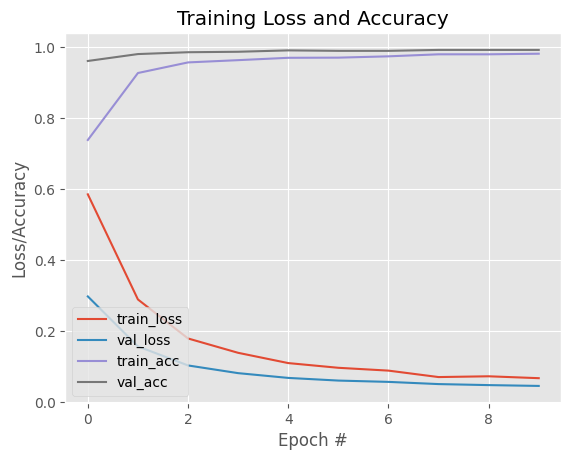

In [22]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")